## Predicting survival of passengers on the titanic

In [103]:
# data analysis and wrangling
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 70)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Machine Learning

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import minmax_scale




In [10]:
training = pd.read_csv('/resources/Machine Learning/Projects/datasets/Titanic_train.csv')
test =pd.read_csv('/resources/Machine Learning/Projects/datasets/Titanic_test.csv')

In [58]:
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# The above tells us implicitly the number of missing entries in each column visualize again
training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin has more than half of the entries missing. what are the unique values

In [15]:
training.Cabin.value_counts().head(10)

G6             4
C23 C25 C27    4
B96 B98        4
C22 C26        3
F33            3
D              3
F2             3
E101           3
E33            2
C68            2
Name: Cabin, dtype: int64

In [11]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


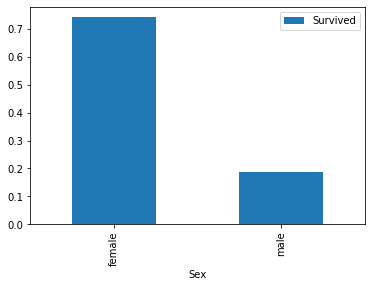

In [4]:
# Visualization
gender_pivot = training.pivot_table(index="Sex",values="Survived")
gender_pivot.plot.bar()
plt.show()

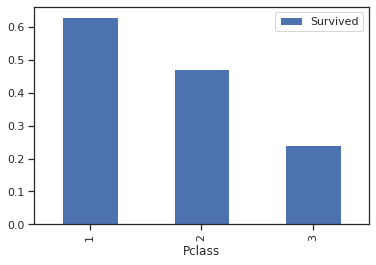

In [7]:
gender_pivot = training.pivot_table(index="Pclass",values="Survived")
gender_pivot.plot.bar()
plt.show()

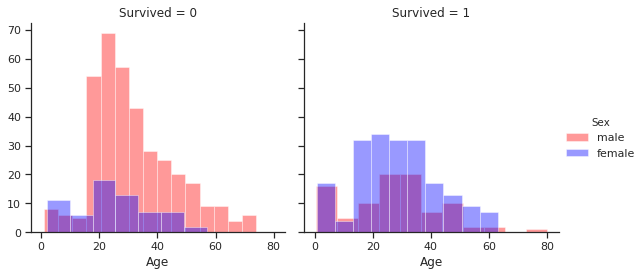

In [14]:
# AGE/sex relationship with Survival 

col = {'color':['red', 'blue']}
sns.set(style ='ticks')
g = sns.FacetGrid(training, col="Survived",hue= 'Sex',hue_kws= col, size=4)
# For each subset of values, generate a kernel density plot of the "Age" columns.
g.map(sns.distplot, "Age", color = 'navy', kde = False, )
g.add_legend()
plt.show()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


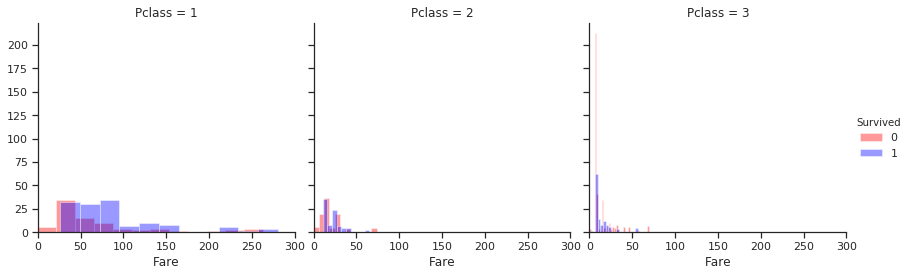

In [4]:
col = {'color':['red', 'blue']}
sns.set(style ='ticks')
g = sns.FacetGrid(training, col="Pclass",hue= 'Survived',hue_kws= col, size=4)
# For each subset of values, generate a kernel density plot of the "Age" columns.
g.map(sns.distplot, "Fare", color = 'navy', kde = False, )
g.add_legend()
plt.xlim(0,300)
plt.show()

Convert columns to Categories
1. Age

In [11]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager", "Young Adult","Adult", "Senior"]

def categorize_age(df,cut_points,label_names):
    """Takes age column and segments it to age ranges based on cut points provided"""
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df


In [12]:
##  Apply categorize_age to training and test sets

training = categorize_age(training, cut_points, label_names)
test = categorize_age(test, cut_points, label_names)

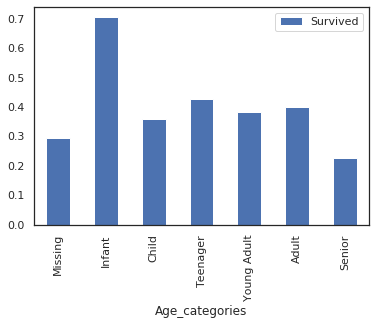

In [61]:
Age_pivot = training.pivot_table(index='Age_categories', values='Survived')
Age_pivot.plot.bar()
plt.show()

In [14]:
#### Collect columns for ML

columns_ml = []

In [15]:




##. Convert sex, pclass and age_category to dummies

# first function
# def create_dummies(df,column_name):
#     """Converts column to dummies and removes the last column of each category"""
#     dummies = pd.get_dummies(df[column_name],prefix=column_name)
#     dummies.drop(dummies.columns[-1], axis = True, inplace = True)
#     print(dummies.columns.tolist())
#     df = pd.concat([df,dummies],axis=1)
#     df.drop(column_name, axis = 1, inplace = True)
#     return df

#modified dummy function
def create_dummies(df,column_name):
    """Converts column to dummies, joins to existing data frame, appends new cols to list for ML after  removing the last column of each category"""
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    dummies.drop(dummies.columns[-1], axis = True, inplace = True)
    if df.shape[0]>test.shape[0]:
        for new_col in dummies.columns.tolist():
             columns_ml.append(new_col)
    else:
        pass
    return df

columns_to_dummies = ['Sex','Pclass','Age_categories']


In [16]:
for i in columns_to_dummies:
    training = create_dummies(training,i)
    test = create_dummies(test,i)
    
columns_ml

['Sex_female',
 'Pclass_1',
 'Pclass_2',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Child',
 'Age_categories_Teenager',
 'Age_categories_Young Adult',
 'Age_categories_Adult']

In [48]:
#Build basic LR model with Age, Sex and class

# columns = ['Pclass_1', 'Pclass_2', 'Sex_female',
#        'Age_categories_Missing','Age_categories_Infant',
#        'Age_categories_Child', 'Age_categories_Teenager',
#        'Age_categories_Young Adult', 'Age_categories_Adult']


In [11]:
lr = LogisticRegression(random_state=20)
lr.fit(training[columns_ml], training['Survived'])
predictions = lr.predict(training[columns_ml])
accuracy_score(training['Survived'],predictions)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8092031425364759

In [12]:
lr = LogisticRegressionCV(cv = 10, random_state=20)
lr.fit(training[columns_ml], training['Survived'])
predictions = lr.predict(training[columns_ml])
accuracy_score(training['Survived'],predictions), precision_score(training['Survived'],predictions)

(0.8080808080808081, 0.7766990291262136)

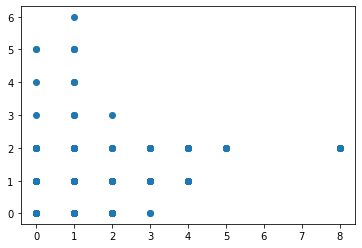

In [24]:
#Add more columns
# 1. analyse Sibsp and Parch

plt.scatter(training.SibSp, training.Parch)
plt.show()

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   PassengerId                 418 non-null    int64   
 1   Pclass                      418 non-null    int64   
 2   Name                        418 non-null    object  
 3   Sex                         418 non-null    object  
 4   Age                         418 non-null    float64 
 5   SibSp                       418 non-null    int64   
 6   Parch                       418 non-null    int64   
 7   Ticket                      418 non-null    object  
 8   Fare                        417 non-null    float64 
 9   Cabin                       91 non-null     object  
 10  Embarked                    418 non-null    object  
 11  Age_categories              418 non-null    category
 12  Sex_female                  418 non-null    uint8   
 13  Pclass_1            

In [17]:
#replace missing value in fare for text with mean
test.Fare = test.Fare.fillna(training.Fare.mean())

In [18]:
# normalize SibSp, Parch and Fare to add to the model
to_scale = ['SibSp', 'Parch', 'Fare']

In [19]:
for column in to_scale:
    training[column + '_scaled'] = minmax_scale(training[column])
    test[column+ '_scaled'] = minmax_scale(test[column])
    columns_ml.append(column+'_scaled')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [20]:
training.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled'],
      dtype='object')

In [57]:
# columns = ['Pclass_1', 'Pclass_2', 'Sex_female',
#        'Age_categories_Missing','Age_categories_Infant',
#        'Age_categories_Child', 'Age_categories_Teenager',
#        'Age_categories_Young Adult', 'Age_categories_Adult'] + to_scale

In [19]:
# New model with the modified columns

lr = LogisticRegressionCV(cv = 5, random_state=20)
lr.fit(training[columns_ml], training['Survived'])
predictions = lr.predict(training[columns_ml])
accuracy_score(training['Survived'],predictions), precision_score(training['Survived'],predictions)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: Convergence

(0.8181818181818182, 0.7960526315789473)

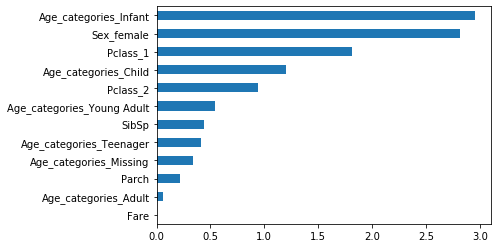

In [41]:
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index= training[columns].columns)
feature_importance.abs().sort_values().plot.barh()
plt.show()

In [58]:
refined_columns = feature_importance.abs().sort_values(ascending=False).head(8).index.tolist()
refined_columns

['Age_categories_Infant',
 'Sex_female',
 'Pclass_1',
 'Age_categories_Child',
 'Pclass_2',
 'Age_categories_Young Adult',
 'SibSp',
 'Age_categories_Teenager']

In [59]:
lr = LogisticRegressionCV(cv = 10, random_state=20)
lr.fit(training[refined_columns], training['Survived'])
predictions = lr.predict(training[refined_columns])
accuracy_score(training['Survived'],predictions), precision_score(training['Survived'],predictions)

(0.813692480359147, 0.782051282051282)

In [66]:

test_predictions = lr.predict(test[columns])
test_predictions


Test_set_id = test.PassengerId

kaggle1 = pd.DataFrame({ 'PassengerID' : Test_set_id,'Survived': test_predictions})
kaggle1.to_csv('/resources/Machine Learning/Projects/datasets/kob_submission1.csv', index =False)

In [63]:
#submission accuracy was 77.9

## More feature engineering and model improvement

Fare column is currently continuous and too granular. what happens when converted to categories

In [21]:
def process_fare(df, cut_points,label_names):
    df['Fare_categories'] = pd.cut(df['Fare'], cut_points , labels = label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ['0-12','12-50','50-100', '100+']
training = process_fare(training,cut_points,label_names)
test = process_fare(test,cut_points,label_names) 

training = create_dummies(training,"Fare_categories")
test = create_dummies(test,"Fare_categories")

In [73]:
# training[training.Survived == 1].Fare_categories.value_counts().plot.barh()
# plt.show()
# training[training.Survived == 0].Fare_categories.value_counts().plot.barh()
# plt.show()

## Title in name could be useful
The right way to do this is to use a regex expression but the following will suffice


In [22]:

training['Title']=training.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
test['Title']=test.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
# training.Title

In [23]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

In [24]:
training.Title = training.Title.map(titles)
test.Title = test.Title.map(titles)
training.Title.head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [25]:
training['Cabin_type'] = training.Cabin.str[0]
training['Cabin_type'] = training['Cabin_type'].fillna('Unknown')
test['Cabin_type'] = test.Cabin.str[0]
test['Cabin_type'] = test['Cabin_type'].fillna('Unknown')

In [26]:
## convert title and cabin type columns to dummies

for column in ['Title','Cabin_type']:
    training = create_dummies(training, column)
    test = create_dummies(test, column)
    

### drop duplicated columns in case of any

In [31]:
training = training.loc[:,~training.columns.duplicated()]
test = test.loc[:,~test.columns.duplicated()]

# drop columns that wont be used in the model

for col in ['Fare_scaled']:
    columns_ml.remove(col)

In [70]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

In [119]:
# # plot_correlation_heatmap(training[columns_ml])
# plt.figure(figsize = (15,12))
# sns.heatmap(training[columns_ml])

## Baseline Model

In [32]:
lr = LogisticRegressionCV(cv = 5, random_state=20)
lr.fit(training[columns_ml], training['Survived'])
predictions = lr.predict(training[columns_ml])
accuracy_score(training['Survived'],predictions), precision_score(training['Survived'],predictions)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: Convergence

(0.8316498316498316, 0.7926829268292683)

## Feature importance*

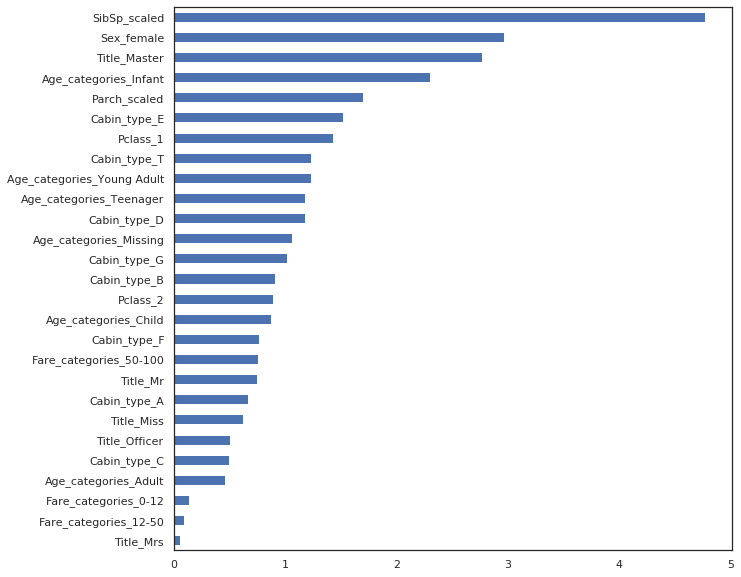

In [103]:
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index= columns_ml)
feature_importance.abs().sort_values().plot.barh(figsize =(10,10))
plt.show()

## More feature engineering
1. Embarked

In [33]:
print(training.Embarked.value_counts(dropna=False))
training.Embarked = training.Embarked.fillna('S')
training.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64


S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [34]:
training = create_dummies(training, 'Embarked')
test = create_dummies(test, 'Embarked')

In [117]:
#########################
## Model with Embarked ##
#########################

lr = LogisticRegressionCV(cv = 5, random_state=20)
lr.fit(training[columns_ml], training['Survived'])
predictions = lr.predict(training[columns_ml])
accuracy_score(training['Survived'],predictions), precision_score(training['Survived'],predictions)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(0.8316498316498316, 0.7944785276073619)

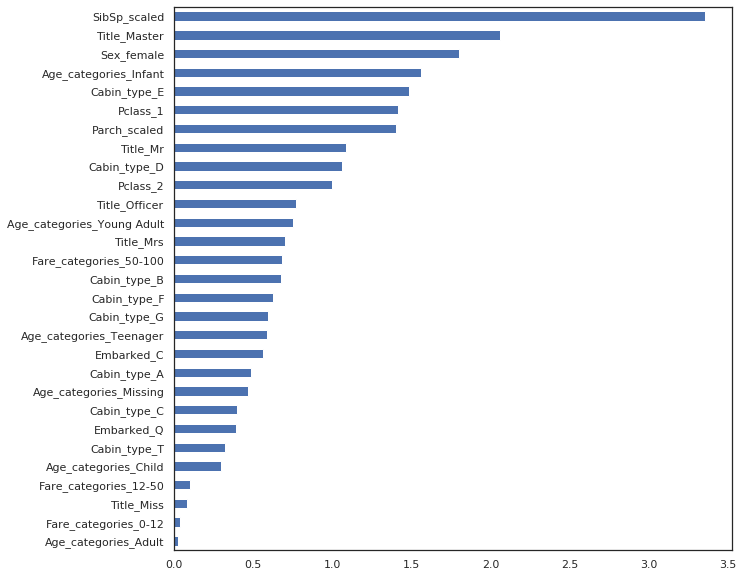

In [118]:
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index= columns_ml)
feature_importance.abs().sort_values().plot.barh(figsize =(10,10))
plt.show()

Adding embarked doesn't seem to affect model much

<Figure size 432x288 with 0 Axes>

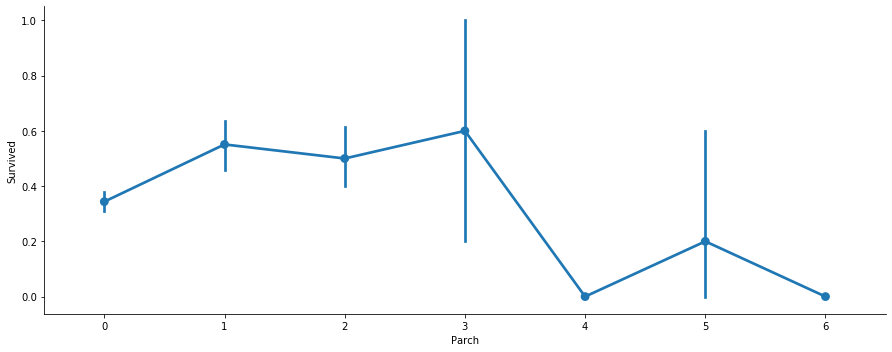

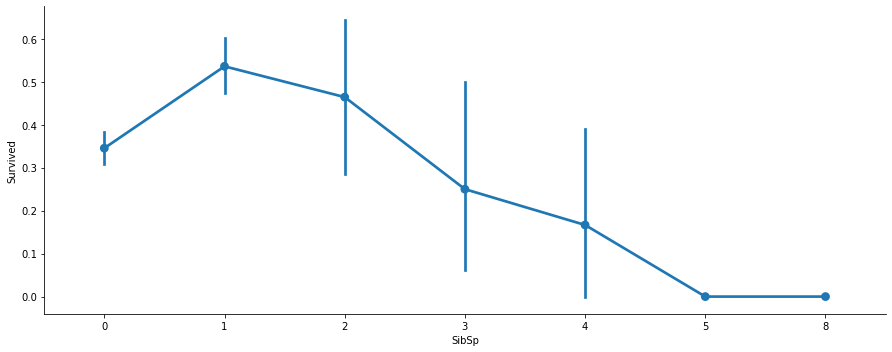

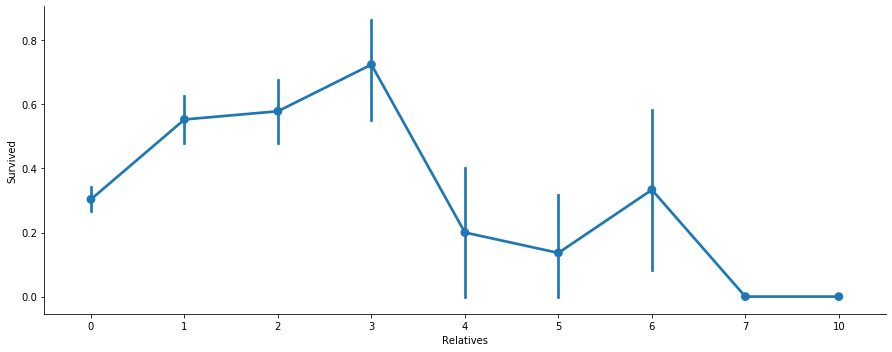

In [47]:
plt.figure(figsize =(6,4))
ax1 = sns.factorplot('Parch','Survived', 
                      data=training, aspect = 2.5, )
ax2 =sns.factorplot('SibSp','Survived', 
                      data=training, aspect = 2.5,)
ax3 =sns.factorplot('Relatives','Survived', 
                      data=training, aspect = 2.5,)
plt.show()

In [48]:
# training['Relatives'] = training.SibSp + training.Parch
training['Relatives_scaled'] = minmax_scale(training.Relatives)
columns_ml.append('Relatives_scaled')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [52]:
training[['Relatives_scaled', 'Parch_scaled', 'SibSp_scaled']].corr()

,Relatives_scaled,Parch_scaled,SibSp_scaled
Relatives_scaled,1.000000,0.783111,0.890712
Parch_scaled,0.783111,1.000000,0.414838
SibSp_scaled,0.890712,0.414838,1.000000


In [54]:
for i in ['Parch_scaled', 'SibSp_scaled']:
    columns_ml.remove(i)

In [55]:
# Model with Relatives

lr = LogisticRegressionCV(cv = 5, random_state=20)
lr.fit(training[columns_ml], training['Survived'])
predictions = lr.predict(training[columns_ml])
accuracy_score(training['Survived'],predictions), precision_score(training['Survived'],predictions)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: Convergence

(0.8338945005611672, 0.7975460122699386)

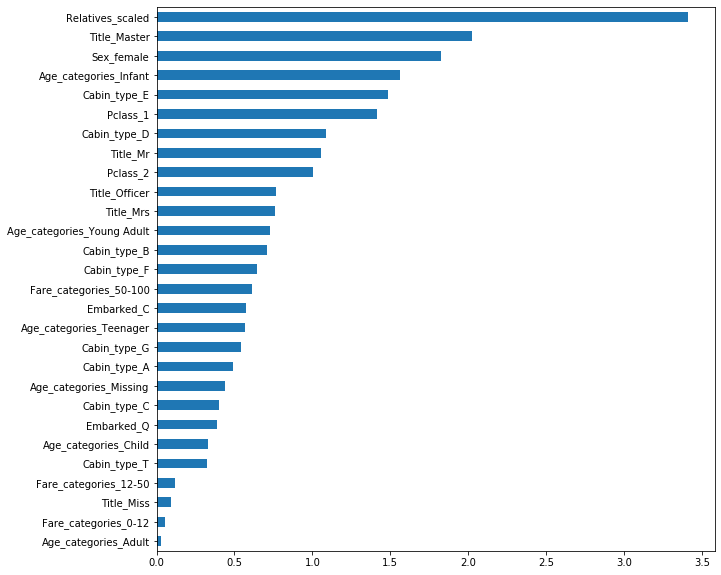

In [56]:
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index= columns_ml)
feature_importance.abs().sort_values().plot.barh(figsize =(10,10))
plt.show()

In [57]:
training.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Fare_categories', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title', 'Cabin_type',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Relatives', 'Relatives_scaled'],
      dtype='object')

In [64]:
# use other labeling for the ordered stuff
# training['Pclass_cat'] = training['Pclass'].astype('category').cat.codes.astype(int)
training['Fare_categories_ordered'] = training['Fare_categories'].astype('category').cat.codes.astype(int)


In [67]:
for i in ['Pclass_1', 'Pclass_2','Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+','Pclass_cat','Fare']:
    if i in columns_ml:
        columns_ml.remove(i)
columns_ml.append('Pclass_cat')
columns_ml.append('Fare_categories_ordered')

In [68]:
columns_ml

['Sex_female',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Child',
 'Age_categories_Teenager',
 'Age_categories_Young Adult',
 'Age_categories_Adult',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Officer',
 'Cabin_type_A',
 'Cabin_type_B',
 'Cabin_type_C',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_F',
 'Cabin_type_G',
 'Cabin_type_T',
 'Embarked_C',
 'Embarked_Q',
 'Relatives_scaled',
 'Pclass_cat',
 'Fare_categories_ordered']

In [100]:
# Test model with modification to encoding

lr = LogisticRegressionCV(cv = 8, random_state=20)
lr.fit(training[columns_ml], training['Survived'])
predictions = lr.predict(training[columns_ml])
accuracy_score(training['Survived'],predictions), precision_score(training['Survived'],predictions)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: Convergence

(0.8395061728395061, 0.8006042296072508)

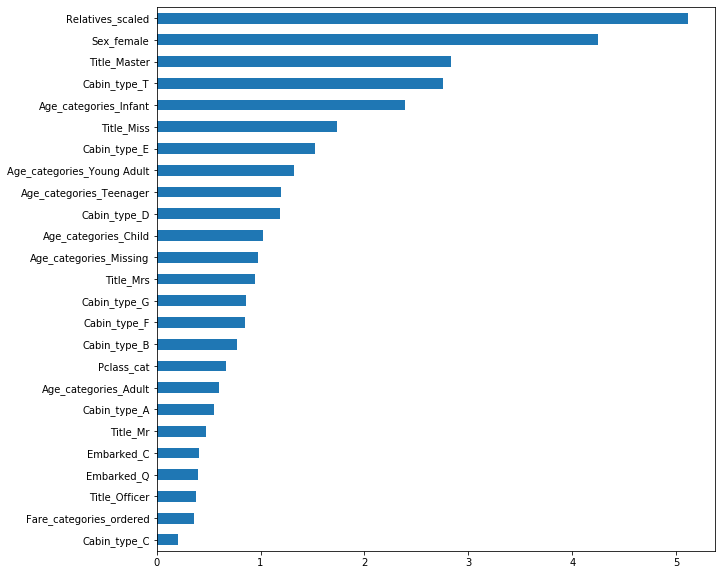

In [70]:
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index= columns_ml)
feature_importance.abs().sort_values().plot.barh(figsize =(10,10))
plt.show()

# Test other classifiers

### KNN

18  neighbours  accuracy:  0.8171189452439452


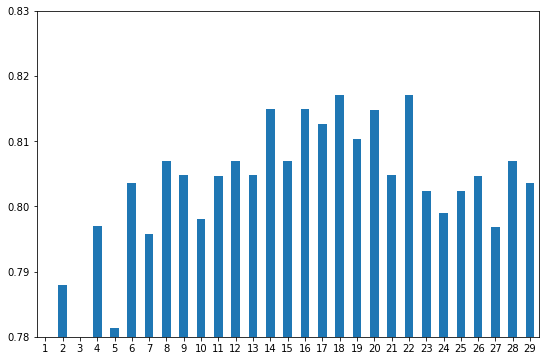

In [99]:
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = {}
for k in range(1,30):
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, training[columns_ml],training.Survived,cv =8)
    accuracy_knn = np.mean(scores)
    knn_scores[k] = accuracy_knn
maxi = max(knn_scores, key=knn_scores.get)
print (maxi, ' neighbours', ' accuracy: ', knn_scores[maxi])
plot_dict(knn_scores)

In [101]:
#logistic regression better than basic 

In [104]:
#Hyperparameter tuning

knn = KNeighborsClassifier()
hyperparameters = {
    "n_neighbors": range(1,20),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

grid = GridSearchCV(knn, param_grid = hyperparameters, cv = 8)

grid.fit(training[columns_ml],training.Survived)
best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 16, 'p': 1, 'weights': 'uniform'}
0.8215488215488216
